#### Import Packages

In [1]:
import os
import random
import implicit
import calendar
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from sklearn import metrics
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from sort_dataframeby_monthorweek import *
from wordcloud import WordCloud, STOPWORDS
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
#To center the graphics
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# To add labels to the end of each bar in a bar chart
def add_value_labels(ax, spacing=5):

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'

        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{:.1f}".format(y_value)

        ax.annotate(
            label,                      
            (x_value, y_value),        
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',               
            va=va)                     
         

#### Importing Data

##### Describe, explore and assess the data

In [4]:
#To read csv files
df = pd.read_csv('retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
#To return a tuple representing the dimensionality of the DataFrame df
df.shape

(541909, 8)

In [6]:
#To return the dtypes in the DataFrame
#In this way, we can start looking better at our data
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
#To print a concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
#To generate descriptive statistics
df.astype(object).describe()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909,541909,541909.00,406829.0,541909
unique,25900,4070,4223,722,23260,1630.00,4372.0,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,10/31/2011 14:41,1.25,17841.0,United Kingdom
freq,1114,2313,2369,148227,1114,50496.00,7983.0,495478


In [9]:
#To count distinct observations over requested axis
#We have more than one description for one stock code
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [10]:
#To summary statistics for all variables
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### Data Preparation and Data Preprocessing

In [11]:
#To check missing data
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
#Total percentage of Nan values in our dataset
df.isnull().sum() / len(df) * 100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [13]:
#To see how many cancellations there are in our dataframe
cancellations = []

for i in range(len(df)):
    if "c" in df["InvoiceNo"].loc[i] or "C" in df["InvoiceNo"].loc[i] :
        cancellations.append(1)
    else:
        pass

print("Number of cancellations: ", len(cancellations))

Number of cancellations:  9288


In [14]:
#To keep rows where Customer ID isn't null
clean_df = df[df['CustomerID'].notna()]
new_customers=df[~df['CustomerID'].notna()]

In [15]:
#To return boolean Series denoting duplicate rows
#As we can see, we have some duplicates
duplicated = clean_df.duplicated().sum()
print("We have",duplicated,"duplicated values")

We have 5225 duplicated values


In [16]:
#To drop duplicate values
clean_df.drop_duplicates(inplace= True)

In [17]:
#To return a tuple representing the dimensionality of the DataFrame clean_df
clean_df.shape

(401604, 8)

In [18]:
#To transform the InvoiceData from object type to data type
clean_df['InvoiceDate'] = pd.to_datetime(clean_df['InvoiceDate'])

In [19]:
#To convert the values in CustomerID from float values to int values
clean_df['CustomerID'] = clean_df['CustomerID'].apply(np.int64)

In [20]:
#To delete negative values from unit price and quantity
#As Eliminating negative values from the colomun 'Quantity' implies that there are no negative values in 'UnitPrice' column, we just delete the negative values from the 'Quantity' column.
clean_neg = clean_df.copy()

clean_df = clean_df[clean_df.Quantity > 0]
negative_clean_df = clean_neg[clean_neg["Quantity"]<0]

print("Number of total negative quantity: ",len(negative_clean_df))

Number of total negative quantity:  8872


In [21]:
#To summary statistics for all variables
clean_df.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


#### Data Exploration

In [22]:
clean_df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

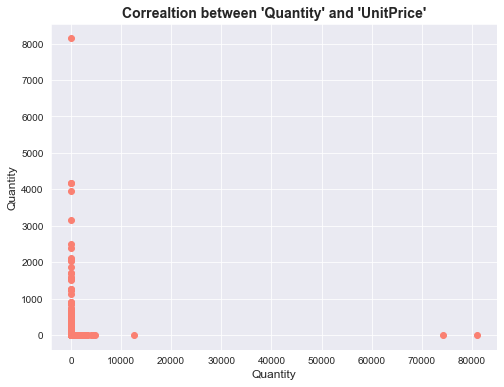

In [23]:
#To see the correlation between the Quantity and the Unit Price
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(clean_df['Quantity'], clean_df['UnitPrice'],  color='salmon')

title = "Correaltion between 'Quantity' and 'UnitPrice'"
plt.title(title,fontsize = 14, fontweight = "bold")
plt.xlabel('Quantity', fontsize = 12)
plt.ylabel('Quantity', fontsize = 12)

plt.show()

In [24]:
#To separate the non_metric_features from metric_features
non_metric_features = clean_df.select_dtypes(include="object").columns.to_list()
non_metric_features.append('InvoiceDate')

metric_features = clean_df.columns.drop(non_metric_features).to_list()

In [ ]:
#To see the pairplot between features
sns.pairplot(clean_df)

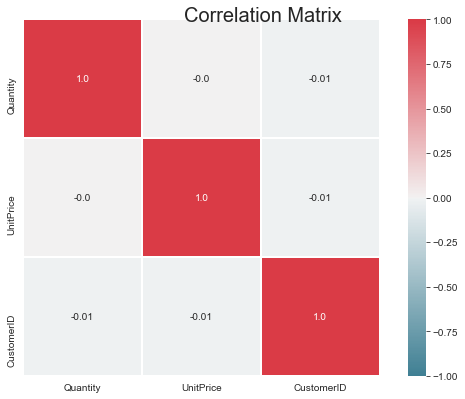

In [26]:
#To see the correlation between the matric variables
# Prepare figure
fig = plt.figure(figsize=(8, 6))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(clean_df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values)>=0
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
           fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)

# Layout
fig.subplots_adjust(top=0.95, left = -0.09)
fig.suptitle("Correlation Matrix", fontsize= 20)

plt.show()

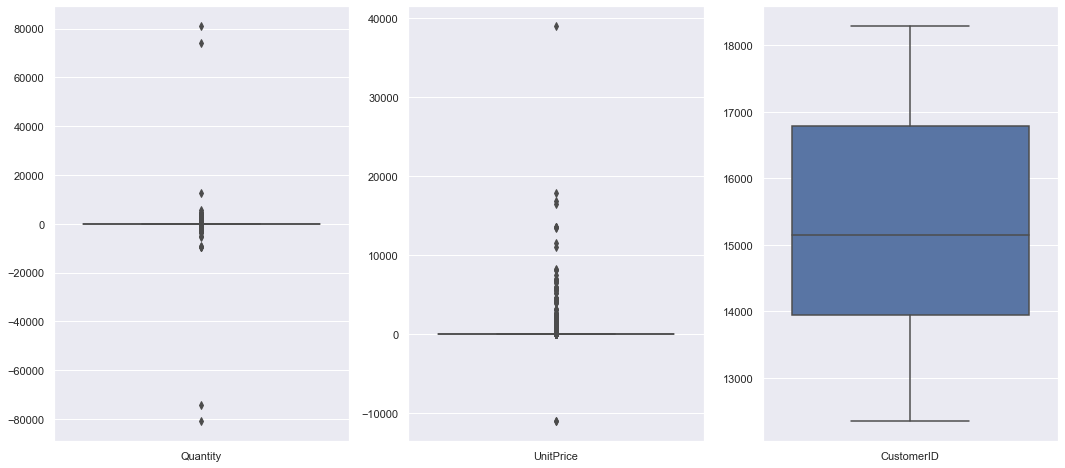

In [27]:
#To do the boxplots
sns.set()

plot_features = clean_df[metric_features].columns
fig, axes = plt.subplots(1, len(plot_features), figsize=(18,8))

j=0
k=1

for i in zip(axes, plot_features):
    sns.boxplot(data=df[metric_features].iloc[:,j:k], ax=i[0])
    
    j=j+1
    k=k+1
    
plt.show()

In [28]:
#To take out outliers to get better plot
z = np.abs(stats.zscore(clean_df[['Quantity','UnitPrice']]))
clean_df = clean_df[(z < 3).all(axis=1)]

In [29]:
#To filter
clean_df = clean_df[(clean_df['Quantity']>=0) | (clean_df['UnitPrice']>=0)]

/Users/catarinamoreira/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "Summary of the 'Quantity' column")

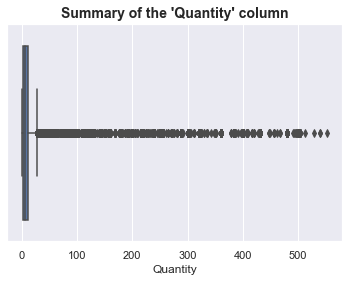

In [30]:
#To show the boxplot of the 'Quantity' column
sns.boxplot(clean_df['Quantity'])

title = "Summary of the 'Quantity' column"
plt.title(title,fontsize = 14, fontweight = "bold")

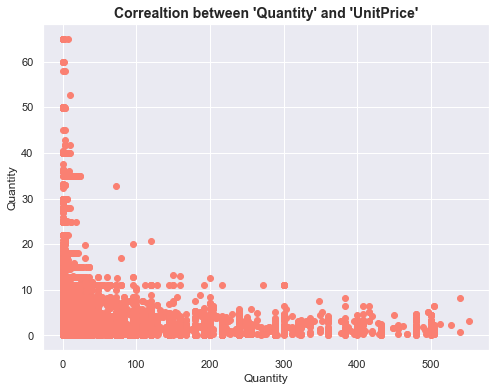

In [31]:
#To show the correaltion between 'Quantity' and 'UnitPrice'
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(clean_df['Quantity'], clean_df['UnitPrice'], color = 'salmon')

title = "Correaltion between 'Quantity' and 'UnitPrice'"
plt.title(title,fontsize = 14, fontweight = "bold")
plt.xlabel('Quantity', fontsize = 12)
plt.ylabel('Quantity', fontsize = 12)

plt.show()

#### Data visualization and Data Understanding

Here, we are going to show some visualizations to understand and to have more insights from the data.

Firstly, let's do a visualization with negative quantity values

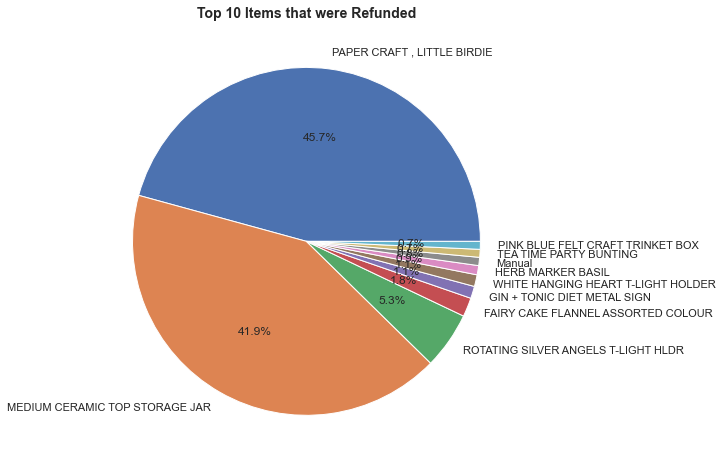

In [32]:
#To show the top 10 items that were refunded
negative_clean_df.Description = negative_clean_df.Description.astype(str)
negative_clean_df.dropna(inplace=True)

negative_clean_df["Description"] = negative_clean_df["Description"].apply(lambda x:np.nan if x.lower() == "nan" else x)

negative_clean_df[['Quantity','Description']].groupby("Description").sum()
negative_clean_df["Quantity"] = abs(negative_clean_df["Quantity"])

plt.figure(figsize=(8,8))
negative_clean_df = negative_clean_df.nlargest(10,columns="Quantity")

plt.title("Top 10 Items that were Refunded",fontsize = 14, fontweight = "bold")
plt.pie(negative_clean_df["Quantity"].to_list(),labels=negative_clean_df.Description,autopct='%1.1f%%')
plt.show()

Paper craft little birdie along with medium ceramic top storage jar are the most refunded.

In [33]:
#To make a copy of the clean_df dataframe
clean_df_visualization = clean_df.copy()

In [34]:
#To create new columns for better analysis
#'Country_map' column -> has the number total in each country
clean_df_visualization['Country_map']= clean_df_visualization.Country.map(clean_df_visualization.Country.value_counts())
#'Price' column
clean_df_visualization['Price']=clean_df_visualization['Quantity']*clean_df_visualization['UnitPrice']
#'Date' column -> Column with the date
clean_df_visualization['Date'] = [d.date() for d in clean_df_visualization['InvoiceDate']]
#'Time' column -> Column with the time
clean_df_visualization['Time'] = [d.time() for d in clean_df_visualization['InvoiceDate']]
#'Month' column -> Column with the month
clean_df_visualization['Month']=[d.month for d in clean_df_visualization['InvoiceDate']]
#'MonthName' column ->Column with the names of month
clean_df_visualization['MonthName']=clean_df_visualization['InvoiceDate'].apply(lambda x:x.strftime("%b"))

In [35]:
#To check the new dataframe
clean_df_visualization.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_map,Price,Date,Time,Month,MonthName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,348723,15.30,2010-12-01,08:26:00,12,Dec
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,348723,20.34,2010-12-01,08:26:00,12,Dec


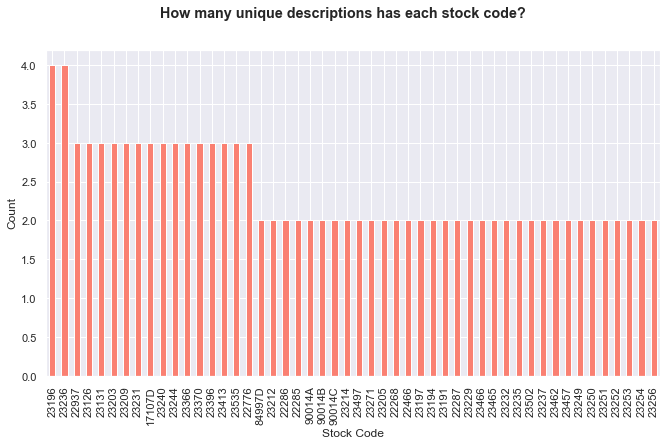

In [36]:
#To check stock code. If each product is associated with a single stock code
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(11,6))
grouped = clean_df_visualization.groupby("StockCode")['Description'].unique()
grouped_counts = grouped.apply(lambda x: len(x)).sort_values(ascending=False)

grouped_counts.head(50).plot(kind = 'bar', color='salmon')

plt.xlabel('Stock Code')
plt.ylabel('Count')
title = "How many unique descriptions has each stock code?"
plt.suptitle(title, fontweight = "bold")

plt.show()

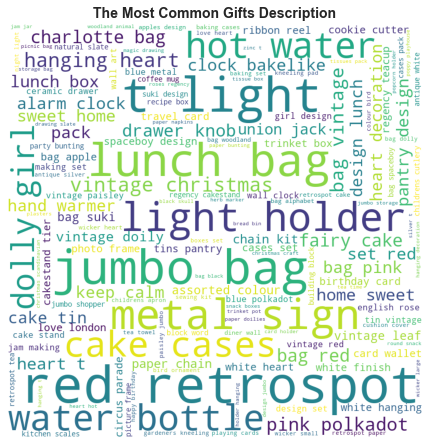

In [37]:
#To know the most common product/gifts description
comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in clean_df_visualization.Description:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
#To plot the WordCloud image                       
plt.figure(figsize = (8,6), facecolor = None)
title = "The Most Common Gifts Description"
plt.title(title,fontsize = 14, fontweight = "bold")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

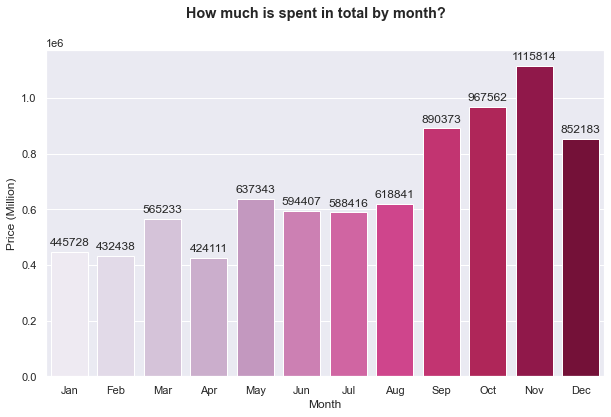

In [38]:
#To visualize the how much the customers spend in the store by month
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

group_month_name_price = (clean_df_visualization.groupby(clean_df_visualization['MonthName']).agg({'Price':'sum'})).reset_index()
group_month_name_price = Sort_Dataframeby_Month(df=group_month_name_price,monthcolumnname='MonthName')
splot = sns.barplot(data = group_month_name_price, x='MonthName', y='Price',palette="PuRd")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xlabel('Month')
plt.ylabel('Price (Million)')
title = "How much is spent in total by month?"
plt.suptitle(title, fontweight = "bold")

plt.show()

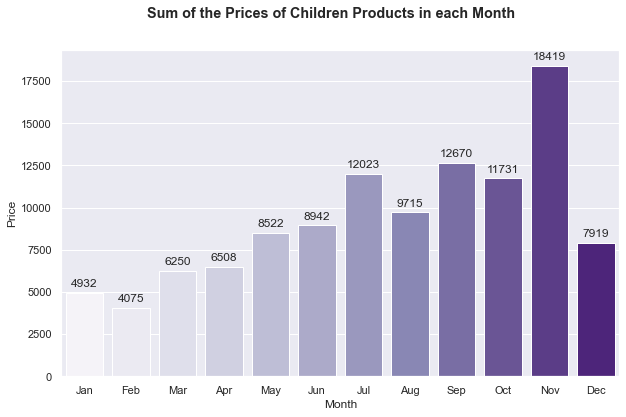

In [39]:
#Analysis on children products
#Variance in buying pattern month wise

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

children=clean_df_visualization.loc[(clean_df_visualization['Description'].str.contains("CHILDRENS|CHILDREN'S",na=False))]
children.reset_index(drop=True)

ch=children.groupby(['MonthName']).agg({'Price':'sum'}).reset_index()
ch= Sort_Dataframeby_Month(df=ch,monthcolumnname='MonthName')

splot = sns.barplot(data = ch, x='MonthName', y='Price',palette="Purples")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xlabel('Month')
plt.ylabel('Price')
title = "Sum of the Prices of Children Products in each Month"
plt.suptitle(title, fontweight = "bold")

plt.show()

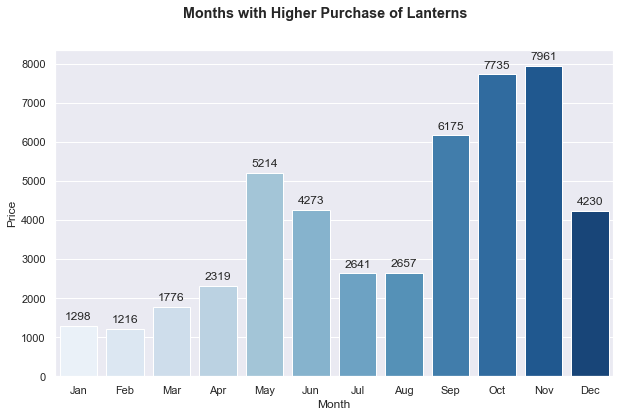

In [40]:
#To see when they sold more lanterns
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

lan=clean_df_visualization.loc[(clean_df_visualization['Description'].str.contains("LANTERN",na=False))]
lan=lan.groupby(['MonthName']).agg({'Price':'sum'}).reset_index()
lan= Sort_Dataframeby_Month(df=lan,monthcolumnname='MonthName')

splot = sns.barplot(data = lan, x='MonthName', y='Price',palette="Blues")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xlabel('Month')
plt.ylabel('Price')
title = "Months with Higher Purchase of Lanterns"
plt.suptitle(title, fontweight = "bold")

plt.show()

In [41]:
#To group by Country and to aggregate the price, quantity and customerID
reg = clean_df_visualization[clean_df_visualization['Price']>=0].groupby('Country').agg({'Price':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count'})

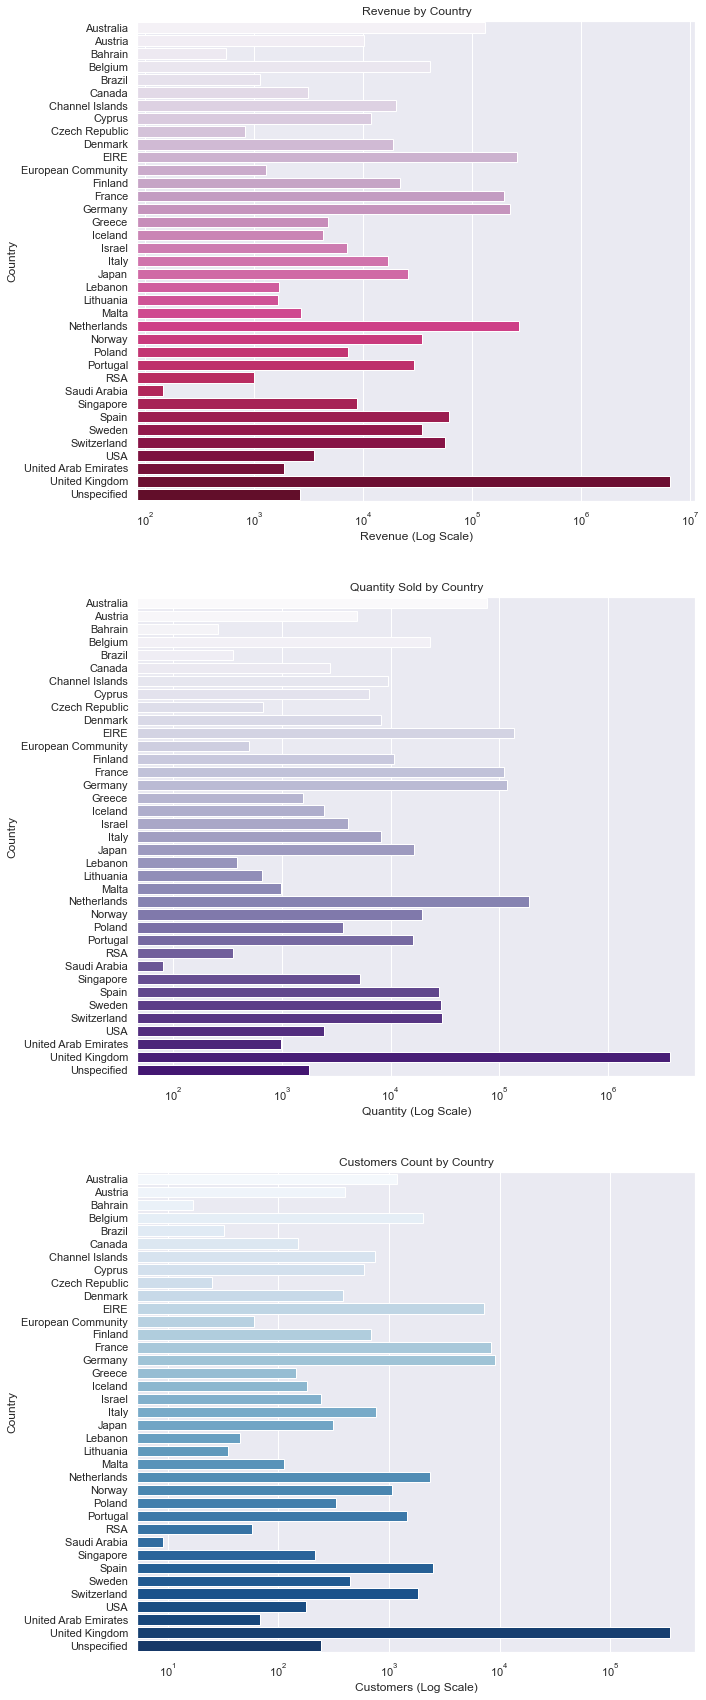

In [42]:
#To check the Revenue, Quantity Sold and Customers Count by Country 
sns.set_style("darkgrid")
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,30))

g1 = sns.barplot(x=reg['Price'], y=reg.index, alpha=1, ax=ax[0],palette='PuRd', orient='h')
g2 = sns.barplot(x=reg['Quantity'], y=reg.index, alpha=1, ax=ax[1], palette='Purples',orient='h')
g3 = sns.barplot(x=reg['CustomerID'], y=reg.index, alpha=1, ax=ax[2], palette='Blues', orient='h')

ax[2].title.set_text('Customers Count by Country')
ax[2].set_xlabel("Customers (Log Scale)")

ax[1].title.set_text('Quantity Sold by Country')
ax[1].set_xlabel("Quantity (Log Scale)")

ax[0].title.set_text('Revenue by Country')
ax[0].set_xlabel("Revenue (Log Scale)")

g1.set_xscale("log")
g2.set_xscale("log")
g3.set_xscale("log")
plt.show()

We can conclude that the major sales is been done from UK. We can also see that almost 95% of all the transactions occurring are from Europe.

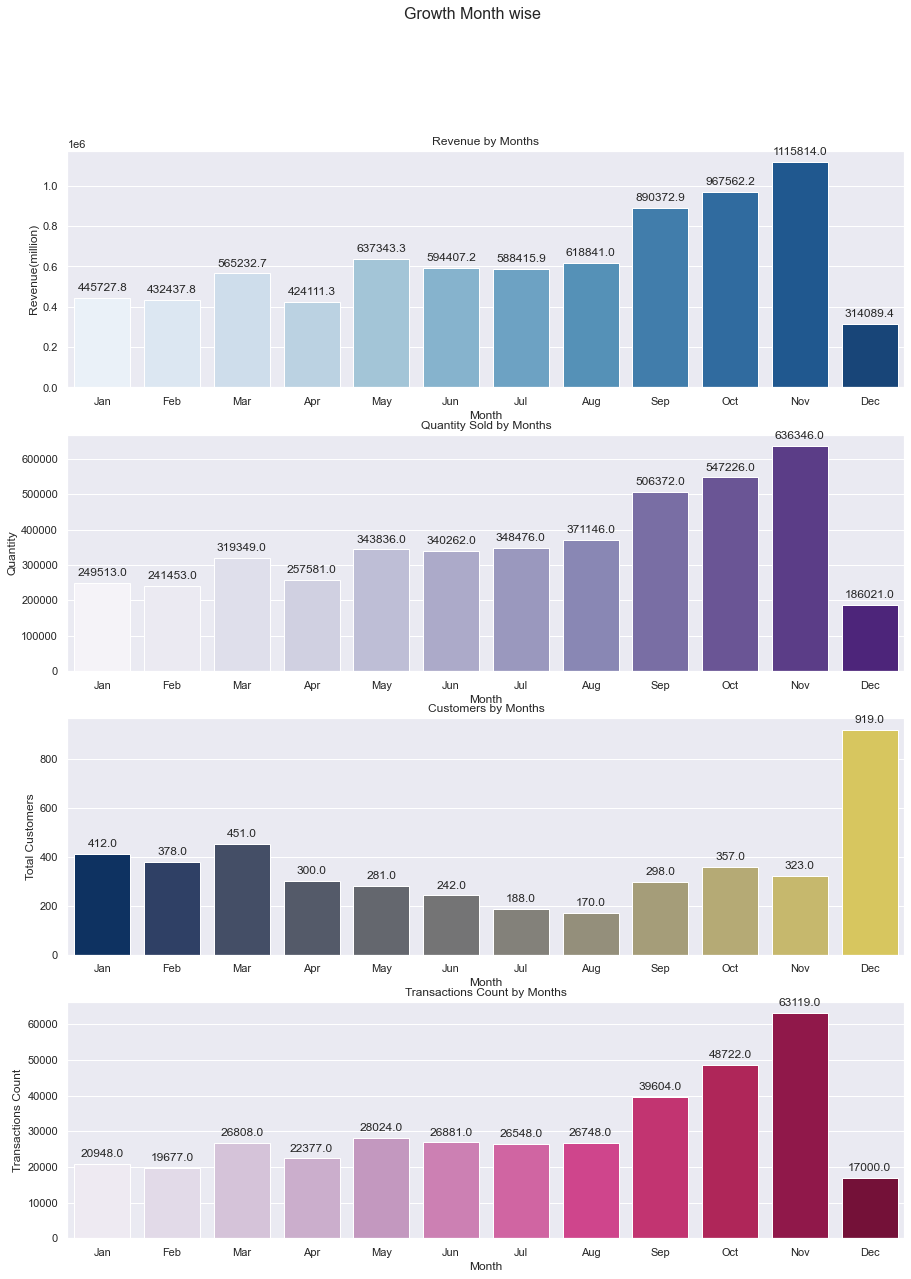

In [43]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))
rev = clean_df_visualization[(clean_df_visualization['Price']>0)&(clean_df_visualization['InvoiceDate'].dt.year==2011)]
rev['Transactions Count'] = 1
rev = rev.groupby(rev['InvoiceDate'].dt.month).agg({'Price':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count',
                                                'Transactions Count':'sum'})
rev = rev.reset_index()
rev['Month'] = rev['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])
rev = rev.rename({'Price':'Revenue'},axis=1)
cust = clean_df_visualization.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
cust = cust.groupby(cust.InvoiceDate.dt.month).agg({'CustomerID':'count'})
cust = cust.reset_index()
cust['Month'] = cust['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])

sns.barplot(data=rev, x=rev.Month, y='Revenue', palette='Blues', ax=ax[0])
ax[0].title.set_text('Revenue by Months')
ax[0].set_ylabel('Revenue(million)')
add_value_labels(ax[0])

sns.barplot(data=rev, x=rev.Month, y='Quantity',  palette='Purples', ax=ax[1])
ax[1].title.set_text('Quantity Sold by Months')
add_value_labels(ax[1])

sns.barplot(data=cust, x=cust.Month, y='CustomerID',  palette='cividis', ax=ax[2])
ax[2].title.set_text('Customers by Months')
ax[2].set_ylabel('Total Customers')
fig.suptitle('Growth Month wise',fontsize=16)
add_value_labels(ax[2])

sns.barplot(data=rev, x=rev.Month, y='Transactions Count',  palette='PuRd', ax=ax[3])
ax[3].title.set_text('Transactions Count by Months')
fig.suptitle('Growth Month wise',fontsize=16)
add_value_labels(ax[3])

plt.show()

#### Modelling

##### Reduce Sparsity

In [46]:
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = (1-float(df.shape[0]) / float(n_users * n_items)) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = (1-float(df.shape[0]) / float(n_users * n_items)) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [47]:
#To get limited dataset
df_limited = threshold_ratings(clean_df, 10, 10)

Raw dataset info 
-----------------
Number of users: 4319
Number of items: 3659
Sparsity: 97.519%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 3748
Number of items: 2859
Sparsity: 96.399%


##### 1st Approach

##### Train-Test split

In [48]:
# Train-test split
start_train = df_limited['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(48, unit='w')
end_test = start_test + pd.to_timedelta(6, unit='w')

# Create new limited df
df_limited = df_limited.loc[(df_limited['InvoiceDate'] > start_train) & (df_limited['InvoiceDate'] <= end_test)]

# Create train_split flag
df_limited['train_split'] = (df_limited['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.80


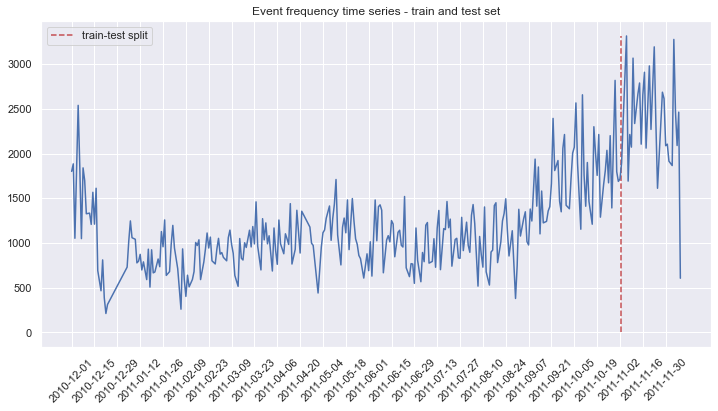

In [49]:
# Visualize train and test set
data = pd.DatetimeIndex(df_limited['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))

plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(14, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')

plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

In [50]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = df_limited['CustomerID'].astype('category')
item_cat = df_limited['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (2859, 3748) and test set shape: (2859, 3748)
train set percentage of zeros: 97.97349305662098 and test set percentage of zeros: 99.388709771946


In [51]:
# initialize a model
alpha = 40  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, iterations=30, random_state=0)

als_model.fit((item_user_train * alpha).astype('double'))

#### ALS model

In [52]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[('82483', 1.0107203),
 ('85123A', 1.007011),
 ('84029G', 1.0060737),
 ('21871', 1.0060601),
 ('82482', 1.0059613),
 ('21068', 1.0028203),
 ('82486', 1.0020049),
 ('22411', 1.0008736),
 ('82494L', 1.0006659),
 ('84029E', 0.9994825)]

In [53]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als_model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[('22633', 1.0),
 ('22866', 0.67414546),
 ('22632', 0.63151526),
 ('22865', 0.611587),
 ('23439', 0.5973944),
 ('22867', 0.58151346),
 ('90086', 0.42863482),
 ('20622', 0.42312282),
 ('20618', 0.41987783),
 ('47469', 0.41704285)]

In [54]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als_model.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the user/item pair is: ", score)
print("The top N (itemid, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the user/item pair is:  0.8074069133627542
The top N (itemid, score) contributions for this user/item pair are:
 [('22633', 0.6254212786978243), ('22632', 0.1629232084144788), ('84029G', 0.027242668733878678), ('84406B', 0.01260995034587378), ('21730', 0.011914548764384133), ('82494L', 0.011713065810165926), ('85123A', 0.010035409602468164), ('22411', 0.007953704795660141), ('21068', 0.005931330455179609), ('84029E', 0.005396616985697788)]


In [55]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [56]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [57]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.086421,0.053672
map,0.039436,0.021821
ndcg,0.090338,0.054276
auc,0.512220,0.507087


# ====================================================================================================

##### 2nd Approach

The next implementation was based on what we learnt from https://github.com/benfred/implicit , where we could find different sources of information which helped us build a better Alternating Least Squares by -------------------

In [58]:
grouped_purchased = df_limited.groupby(['CustomerID', 'StockCode']).sum().reset_index()

In [59]:
customers = list(np.sort(grouped_purchased.CustomerID.unique())) # Get our unique customers
products = list(grouped_purchased.StockCode.unique()) # Get our unique products that were purchased
quantity = list(grouped_purchased.Quantity) # All of our purchases

cat_type1 = CategoricalDtype(categories=customers)
cat_type2 = CategoricalDtype(categories=products)
rows = grouped_purchased['CustomerID'].astype(cat_type1).cat.codes
# Get the associated row indices
cols = grouped_purchased['StockCode'].astype(cat_type2).cat.codes
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

In [60]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

97.56700833892334

In [61]:
def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  

In [62]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

In [63]:
alpha = 15
item_user_data = (product_train*alpha).astype('double')

model = implicit.als.AlternatingLeastSquares(factors=20, regularization = 0.1, iterations = 50)
model.fit(item_user_data.T)

user_vecs = model.user_factors
item_vecs = model.item_factors

In [64]:
user_vecs.shape

(3748, 20)

In [65]:
item_vecs.shape

(2859, 20)

In [68]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [70]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(product_train)

In [73]:
# Evaluate models.
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, product_train, product_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.013257,0.049786
map,0.005832,0.018044
ndcg,0.015772,0.050664
auc,0.499150,0.504914


In [74]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr) 

In [75]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmar

In [76]:
predictions=[sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)]
calc_mean_auc(product_train, 
              product_users_altered, 
              predictions, product_test)
# AUC for our recommender system

(0.851, 0.771)

#### Recommendation Results

In [77]:
#Array of customer IDs from the ratings matrix
customers_arr = np.array(customers)
#Array of product IDs from the ratings matrix
products_arr = np.array(products)

In [78]:
def get_items_purchased(customer_id, mf_train, customers_list, products_list, item_lookup):
    #To returns the index row of our customer id
    cust_ind = np.where(customers_list == customer_id)[0][0] 
    #To get column indices of purchased items
    purchased_ind = mf_train[cust_ind,:].nonzero()[1] 
    #To get the stock codes for our purchased items
    prod_codes = products_list[purchased_ind] 
    return item_lookup.loc[item_lookup.StockCode.isin(prod_codes)]

In [79]:
#Only get unique item/description pairs
item_lookup = df_limited[['StockCode', 'Description']].drop_duplicates() 
#Encode as strings for future lookup ease
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) 

In [80]:
item_lookup.head()

,StockCode,Description
7,22633,HAND WARMER UNION JACK
8,22632,HAND WARMER RED POLKA DOT
9,84879,ASSORTED COLOUR BIRD ORNAMENT
10,22745,POPPY'S PLAYHOUSE BEDROOM
11,22748,POPPY'S PLAYHOUSE KITCHEN


In [89]:
#Purchased Items
print(get_items_purchased(12348, product_train, customers_arr, products_arr, item_lookup))

       StockCode                         Description
45          POST                             POSTAGE
98         21977  PACK OF 60 PINK PAISLEY CAKE CASES
99         84991         60 TEATIME FAIRY CAKE CASES
298        21980   PACK OF 12 RED RETROSPOT TISSUES 
406        21213         PACK OF 72 SKULL CAKE CASES
409        84992      72 SWEETHEART FAIRY CAKE CASES
649        22616          PACK OF 12 LONDON TISSUES 
1263       21982            PACK OF 12 SUKI TISSUES 
1264       21981        PACK OF 12 WOODLAND TISSUES 
1265       21967            PACK OF 12 SKULL TISSUES
3889       22437       SET OF 9 BLACK SKULL BALLOONS
3998       21211      SET OF 72 SKULL PAPER  DOILIES
7347       84988  SET OF 72 PINK HEART PAPER DOILIES
11981      21725                  SWEETIES  STICKERS
131403     23077                 DOUGHNUT LIP GLOSS 
131472     23076          ICE CREAM SUNDAE LIP GLOSS
131649     23078            ICE CREAM PEN LIP GLOSS 


In [90]:
print(get_items_purchased(18230, product_train, customers_arr, products_arr, item_lookup))

       StockCode                          Description
117        21169      YOU'RE CONFUSING ME METAL SIGN 
119        21175          GIN + TONIC DIET METAL SIGN
261        85152      HAND OVER THE CHOCOLATE   SIGN 
334        21463                 MIRRORED DISCO BALL 
335        21464  DISCO BALL ROTATOR BATTERY OPERATED
341        82580                  BATHROOM METAL SIGN
343        82581                    TOILET METAL SIGN
344        22413      METAL SIGN TAKE IT OR LEAVE IT 
639        21790                   VINTAGE SNAP CARDS
689        21892   TRADITIONAL WOODEN CATCH CUP GAME 
1203       21179              NO JUNK MAIL METAL SIGN
1386       48138                   DOORMAT UNION FLAG
2155       21181         PLEASE ONE PERSON METAL SIGN
2301       21864      UNION JACK FLAG PASSPORT COVER 
3504       82582            AREA PATROLLED METAL SIGN
3636       21163   DO NOT TOUCH MY STUFF DOOR HANGER 
3638       21161           KEEP OUT BOYS DOOR HANGER 
4214       21911            

This function will return the top recommended items to our users parameters:

- customer_id - Input the customer's id number that you want to get recommendations for

- mf_train - The training matrix you used for matrix factorization fitting

- user_vecs - the user vectors from your fitted matrix factorization

- item_vecs - the item vectors from your fitted matrix factorization

- customer_list - an array of the customer's ID numbers that make up the rows of your ratings matrix (in order of matrix)

- item_list - an array of the products that make up the columns of your ratings matrix (in order of matrix)

- item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available

- num_items - The number of items you want to recommend in order of best recommendations. Default is 10. 

###### returns:
The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased

In [83]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    
    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order 
    # of best recommendations
    rec_list = [] # start empty list to store items
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]]) 
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions}) # Create a dataframe 
    return final_frame[['StockCode', 'Description']] # Switch order of columns around

In [91]:
print(rec_items(12348, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10))

  StockCode                          Description
0     84692          BOX OF 24 COCKTAIL PARASOLS
1     23119        PACK OF 6 LARGE FRUIT STRAWS 
2     23309  SET OF 60 I LOVE LONDON CAKE CASES 
3     21974     SET OF 36 PAISLEY FLOWER DOILIES
4     23155  KNICKERBOCKERGLORY MAGNET ASSORTED 
5    84596B   SMALL DOLLY MIX DESIGN ORANGE BOWL
6     22197                 SMALL POPCORN HOLDER
7     23154             SET OF 4 JAM JAR MAGNETS
8     21212      PACK OF 72 RETROSPOT CAKE CASES
9     84987      SET OF 36 TEATIME PAPER DOILIES


In [92]:
print(rec_items(18230, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10))

  StockCode                    Description
0     85150  LADIES & GENTLEMEN METAL SIGN
1     82600          NO SINGING METAL SIGN
2     22467              GUMBALL COAT RACK
3     82578             KITCHEN METAL SIGN
4     21908  CHOCOLATE THIS WAY METAL SIGN
5     72741          GRAND CHOCOLATECANDLE
6     22115          METAL SIGN EMPIRE TEA
7     82583           HOT BATHS METAL SIGN
8     21166     COOK WITH WINE METAL SIGN 
9     20963              APPLE BATH SPONGE


#### Cold Start Problem

In [101]:
#To return 5 rows from new_customers table
new_customers.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [102]:
#To transform the InvoiceData from object type to data type
new_customers['InvoiceDate'] = pd.to_datetime(new_customers['InvoiceDate'])

In [103]:
#To create new column
new_customers['Month']=[d.month for d in new_customers['InvoiceDate']]

In [104]:
b = new_customers.groupby(['Description'])['Quantity'].sum()
b = b.reset_index()
b = b.sort_values(by=['Quantity'], ascending = False).head(10)
b

,Description,Quantity
586,CHARLOTTE BAG SUKI DESIGN,9177
2274,POPCORN HOLDER,5830
2391,RED RETROSPOT CHARLOTTE BAG,4962
3364,WOODLAND CHARLOTTE BAG,4073
2032,PAPER CHAIN KIT 50'S CHRISTMAS,3738
2327,RABBIT NIGHT LIGHT,3586
3445,came coded as 20713,3100
2057,PARTY BUNTING,2995
2994,STRAWBERRY CHARLOTTE BAG,2951
1995,PACK OF 72 RETROSPOT CAKE CASES,2630


In [105]:
new_customers.Description = new_customers.Description[new_customers.Description != '?']

In [106]:
new_customers['Description'] = new_customers['Description'].map(str)  
new_customers['Description'] =  new_customers['Description'].apply(lambda x: x if x.isupper() else None)

In [107]:
df_agg = new_customers.groupby(['Month', 'Description']).agg({'Quantity':sum})

In [108]:
g = df_agg['Quantity'].groupby('Month', group_keys=False)

In [109]:
res = g.apply(lambda x: x.sort_values(ascending=False).head(3))

In [110]:
g.nlargest(3)

Month  Description                        
1      CHARLOTTE BAG SUKI DESIGN               629
       STRAWBERRY SHOPPER BAG                  523
       JUMBO BAG CHARLIE AND LOLA TOYS         323
2      CHARLOTTE BAG SUKI DESIGN               549
       STRAWBERRY CERAMIC TRINKET BOX          241
       WOODLAND CHARLOTTE BAG                  196
3      CHARLOTTE BAG SUKI DESIGN               847
       SMALL POPCORN HOLDER                    769
       WOODLAND CHARLOTTE BAG                  549
4      CHARLOTTE BAG SUKI DESIGN               387
       PARTY BUNTING                           326
       WOODLAND CHARLOTTE BAG                  250
5      ASSORTED COLOURS SILK FAN               796
       PARTY BUNTING                           540
       CHARLOTTE BAG SUKI DESIGN               462
6      CHARLOTTE BAG SUKI DESIGN               439
       PARTY BUNTING                           394
       SET/6 RED SPOTTY PAPER PLATES           304
7      PARTY BUNTING                   